<a href="https://colab.research.google.com/github/chenant2017/MathModeling/blob/main/Roller_coaster_ranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn import metrics

gc = gspread.authorize(GoogleCredentials.get_application_default())

ApplicationDefaultCredentialsError: ignored

In [ ]:
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/16UAKkbTQ_M7aPvgsfYNB36jzpf73H7bs5Hrke0FDq7k/edit#gid=0')
sheet = wb.worksheet('Sheet1')
data = sheet.get_all_records()
rdf = pd.DataFrame(data)

In [ ]:
## Fill with mean
def fillNaN(df):
  df = pd.DataFrame({k: [np.nan if x == "" else x for x in df[k]] for k in df})
  return df.fillna(df.median())

def GetPercentile(n):
  r = np.array(range(n))
  return np.floor(r/n*100).astype(np.int)

def Percentile(df, columns):
  nrows = df.shape[0]
  percentiles = GetPercentile(nrows)
  result = {}
  for c in columns:
    result[c] = pd.Series(percentiles, df[[c]].sort_values(by=c).index)
  return pd.DataFrame(result)

def normal(v):
  min = v.min()
  max = v.max()
  return (v - min)/(max - min)

def log_normal(v):
  return normal(np.log(v))

In [ ]:
rdf = fillNaN(rdf)
df = rdf.drop(["Duration (min:sec)", 'Length (predicted)', "", "Length/Speed"], axis = 1)
ndf = pd.DataFrame({
    "inversions": normal(df["Number of Inversions"] + 1),
    "date": normal(2019 - df["Year/Date Opened"]),
    "height": normal(df["Height (feet)"]),
    "speed": normal(df["Speed (mph)"]),
    "drop": normal(df["Drop (feet)"]),
    "length": normal(df["Length (feet)"]),
    "g-force": normal(df["G Force"]),
    "angle": normal(df["Vertical Angle (degrees)"]),
    "time": normal(df["time in decimals(minute)"])
})

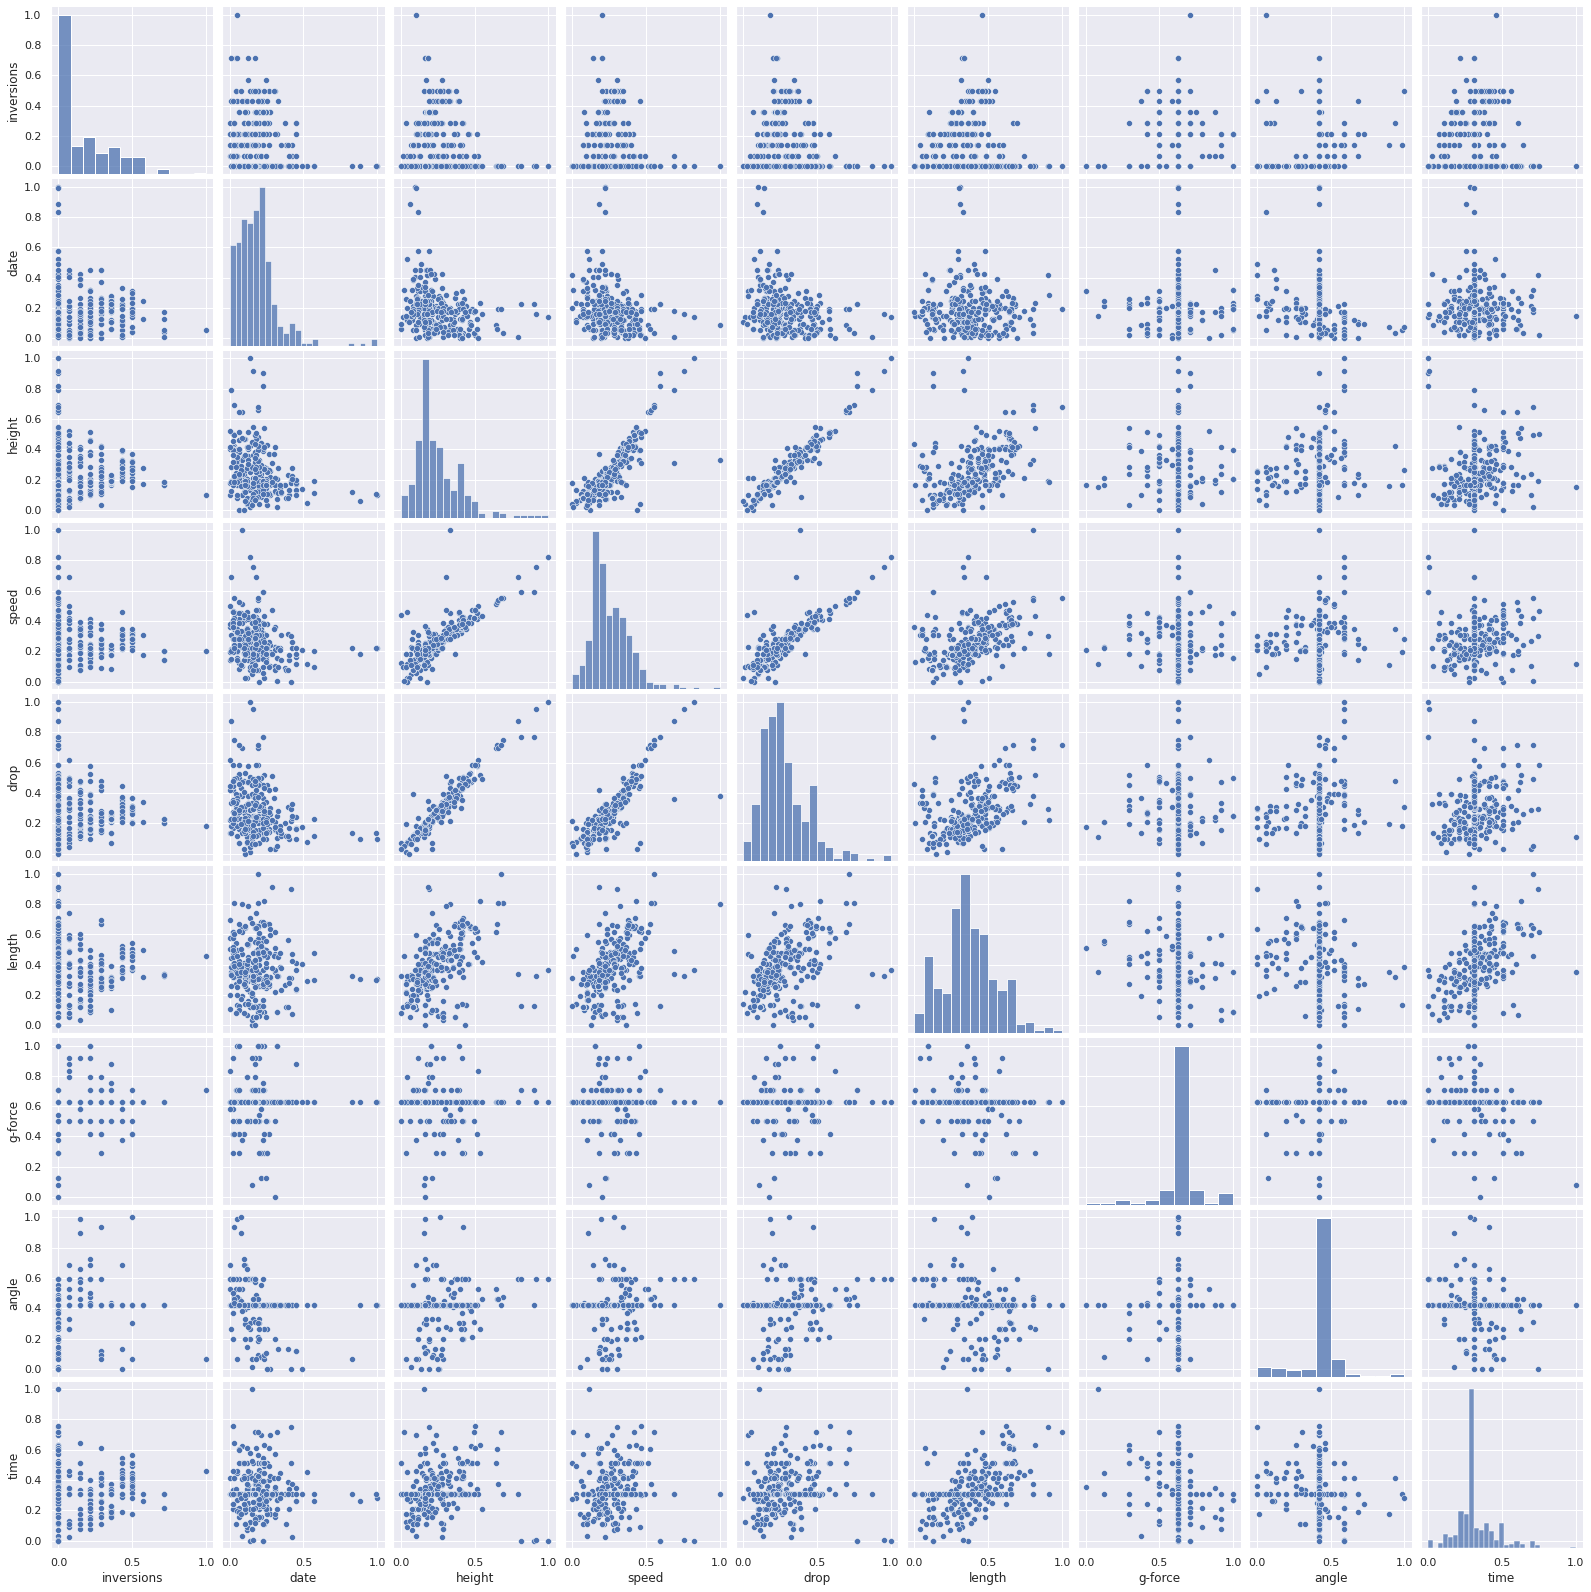

In [ ]:
sns.pairplot(ndf)

In [ ]:
ndf.head()

,inversions,date,height,speed,drop,length,g-force,angle,time
0,0.714286,0.127660,0.162529,0.140380,0.201591,0.325049,0.625,0.421053,0.215488
1,0.142857,0.127660,0.287119,0.307184,0.334931,0.159304,0.500,0.421053,0.107744
2,0.214286,0.000000,0.100703,0.140380,0.135422,0.105453,0.625,0.684211,0.309764
3,0.428571,0.202128,0.196721,0.280760,0.238184,0.346165,0.625,0.421053,0.468013
4,0.428571,0.223404,0.388759,0.322048,0.365729,0.456291,0.375,0.421053,0.545455


In [ ]:
ndf.shape

(300, 9)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

def pca(A, n=2):
  # create the PCA instance
  p = PCA(n)  # fit on data
  p.fit(A)
  cvar = p.explained_variance_
  cvar = np.round(np.cumsum(cvar/cvar.sum()),4)
  print ("variance explained: ", cvar)
  return p.transform(A), p

# Compute entropy
def entropy(x):
  return -(x*np.log(x+1e-7)).sum()

"""
Compute entropy weighting

Args:
 X: a normalized DataFrame.
"""
def entropyWeight(X):
  p = X.apply(lambda x: x/x.sum())
  d = 1-p.apply(lambda x: entropy(x)/np.log(len(x)))
  return d/d.sum()

def topsis(X, bestcase, worstcase, w):
  d1 = X.apply(lambda x: np.power(x-bestcase, 2).dot(w), axis = 1)
  d0 = X.apply(lambda x: np.power(x-worstcase, 2).dot(w), axis = 1)
  return (d0/(d0+d1))

In [ ]:
ndf2, mpca = pca(ndf, 2)
ndf3 = pd.DataFrame({
  "pc1": ndf2[:, 0],
  "pc2": ndf2[:, 1]
})

best = np.array([1,0,1,1,1,1,1,1,0])
worst = 1 - best

cases = np.reshape(np.array([best, worst]), (2, 9))
extremes = mpca.transform(cases)

best = extremes[0,:]
worst = extremes[1,:]


variance explained:  [0.666 1.   ]


In [ ]:
w = [0.666, 1-0.666]
rank = topsis(ndf3, best, worst, w)
df["Rank"] = rank

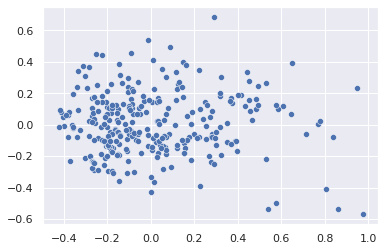

In [ ]:
sns.scatterplot(x=ndf2[:,0], y=ndf2[:, 1])

In [ ]:
df.sort_values(by="Rank", ascending=False).head(10)

,Name,Park,City/Region,City/State/Region,Country/Region,Geographic Region,Construction,Type,Status,Year/Date Opened,Height (feet),Speed (mph),Length (feet),Inversions (YES or NO),Number of Inversions,Drop (feet),G Force,Vertical Angle (degrees),time in decimals(minute),Rank
146,Kingda Ka,Six Flags Great Adventure,Jackson,New Jersey,United States,North America,Steel,Sit Down,Operating,2005,456.0,128.0,3118.0,NO,0,418.000,4.3,90.0,0.466667,0.950387
273,Top Thrill Dragster,Cedar Point,Sandusky,Ohio,United States,North America,Steel,Sit Down,Operating,2003,420.0,120.0,2800.0,NO,0,400.000,4.3,90.0,0.500000,0.921913
208,Red Force,Ferrari Land,Salou,Tarragona,Spain,Europe,Steel,Sit Down,Operating,2017,367.3,111.8,2887.2,NO,0,369.344,4.3,90.0,2.000000,0.876321
254,Superman: Escape from Krypton,Six Flags Magic Mountain,Valencia,California,United States,North America,Steel,Sit Down,Operating,1997,415.0,100.0,1235.0,NO,0,328.100,4.5,77.0,0.466667,0.803167
275,Tower of Terror II,Dreamworld,Coomera,Queensland,Australia,Oceana,Steel,Sit Down,Operating,1997,377.3,100.0,1235.0,NO,0,328.100,4.5,90.0,0.466667,0.793318
103,Fury 325,Carowinds,Charlotte,North Carolina,United States,North America,Steel,Sit Down,Operating,2015,325.0,95.0,6602.0,NO,0,320.000,4.3,81.0,2.000000,0.784626
151,Leviathan,Canada's Wonderland,Vaughan,Onterio,Canada,North America,Steel,Sit Down,Operating,2012,306.0,92.0,5486.0,NO,0,306.000,4.3,80.0,3.466667,0.723352
131,Intimidator 305,Kings Dominion,Doswell,Virginia,United States,North America,Steel,Sit Down,Operating,2010,305.0,90.0,5100.0,NO,0,300.000,4.3,85.0,3.000000,0.721943
163,Millennium Force,Cedar Point,Sandusky,Ohio,United States,North America,Steel,Sit Down,Operating,2000,310.0,93.0,6595.0,NO,0,300.000,4.3,80.0,2.333333,0.720108
239,Steel Dragon 2000,Nagashima Spa Land,Nagashima,"Kuwana,, Mie",Japan,Asia,Steel,Sit Down,Operating,2000,318.3,95.0,8133.2,NO,0,306.800,4.3,77.0,4.000000,0.710581
